In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.chdir("/content/drive/My Drive/HAR Dataset/HAR Mine")

In [3]:
!ls "/content/drive/My Drive/HAR Dataset/HAR Mine"
!cp "/content/drive/My Drive/HAR Dataset/HAR Mine/Processed Data/accelerometer_extracted_featured_data_without_overlapping.csv" "accelerometer_extracted_featured_data_without_overlapping.csv"

 acc_data_4sec_before_3sec_after.csv
 acc_data_4sec_before_3sec_after_with_magnitude.csv
 accelerometer_extracted_featured_data_without_overlapping.csv
'Basic Data'
 checkpoint
 human_activity_recognition_basic.ipynb
 human_activity_recognition_Classifier.ipynb
 Human_activity_recognition_feature_extract.ipynb
 human_activity_recognition_MINE.ipynb
'Processed Data'


# Load Library

In [0]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

# Load Data

In [0]:
#columns = ['user','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']
df = pd.read_csv('Processed Data/accelerometer_extracted_featured_data_without_overlapping.csv')
#df = pd.read_csv('Processed Data/accelerometer_extracted_featured_data_without_overlapping.csv')
#, header = None, names = columns
df = df.dropna()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1261 entries, 0 to 1260
Data columns (total 33 columns):
mean_x              1261 non-null float64
mean_y              1261 non-null float64
mean_z              1261 non-null float64
magnitude_mean      1261 non-null float64
std_x               1261 non-null float64
std_y               1261 non-null float64
std_z               1261 non-null float64
magnitude_std       1261 non-null float64
rms_x               1261 non-null float64
rms_y               1261 non-null float64
rms_z               1261 non-null float64
magnitude_rms       1261 non-null float64
min_x               1261 non-null float64
min_y               1261 non-null float64
min_z               1261 non-null float64
magnitude_min       1261 non-null float64
max_x               1261 non-null float64
max_y               1261 non-null float64
max_z               1261 non-null float64
magnitude_max       1261 non-null float64
median_x            1261 non-null float64
median_y   

# Data Exploration

The columns we will be most interested in are activity, x-axis, y-axis and z-axis. Let's dive into the data:

In [7]:
df.head()
#print(df['mean_x'])
#print(df['mean_x'].values[0])


,mean_x,mean_y,mean_z,magnitude_mean,std_x,std_y,std_z,magnitude_std,rms_x,rms_y,rms_z,magnitude_rms,min_x,min_y,min_z,magnitude_min,max_x,max_y,max_z,magnitude_max,median_x,median_y,median_z,magnitude_median,mad_x,mad_y,mad_z,magnitude_mad,corr_xy,corr_yz,corr_xz,subject,class
0,-1.644151,7.299989,-4.774019,9.194468,1.374718,1.303727,1.601727,0.633384,2.143148,7.415493,5.035552,9.216258,-3.890869,4.947205,-7.264801,7.616315,1.022034,10.116287,-0.647232,10.606999,-1.443993,7.268387,-4.960381,9.253738,1.145463,1.075877,1.239351,0.493521,0.803482,0.755901,0.724554,2,SITTING
1,-4.893322,2.375117,-8.347987,10.039573,0.647945,1.077232,0.453523,0.517292,4.936034,2.607989,8.360298,10.052891,-5.834961,0.261749,-9.491409,8.587557,-2.504623,5.095642,-7.202560,11.571552,-4.917984,1.873054,-8.333808,10.034463,0.466141,0.848993,0.334032,0.331420,0.147029,0.330089,0.287061,2,SITTING
2,-4.714092,1.146173,-8.771570,10.045569,0.542208,0.410817,0.462359,0.489795,4.745172,1.217573,8.783748,10.057503,-6.402389,-0.492416,-10.326981,9.372080,-3.649048,2.102890,-7.968704,12.089280,-4.677368,1.134445,-8.762375,9.961059,0.364911,0.280063,0.326969,0.301609,0.287382,0.298514,0.050644,2,SITTING
3,-4.440626,1.069510,-8.864417,9.972461,0.071734,0.047943,0.063884,0.049366,4.441206,1.070584,8.864647,9.972584,-4.570816,0.944107,-8.995804,9.865092,-4.271545,1.226624,-8.758789,10.071942,-4.436752,1.070999,-8.861740,9.964040,0.059195,0.035829,0.051725,0.042919,0.194947,0.208995,-0.454511,2,SITTING
4,-4.375648,0.917478,-8.933562,9.991692,0.120399,0.155448,0.059223,0.069623,4.377304,0.930554,8.933758,9.991934,-4.709686,0.434143,-9.072418,9.695230,-3.852570,1.159576,-8.753998,10.174546,-4.358940,0.938118,-8.938354,10.006441,0.077469,0.110670,0.045394,0.043270,-0.026265,0.537605,-0.009120,2,SITTING


['SITTING' 'STANDING' 'WALKING' 'WALKING_DOWNSTAIRS' 'WALKING_UPSTAIRS']


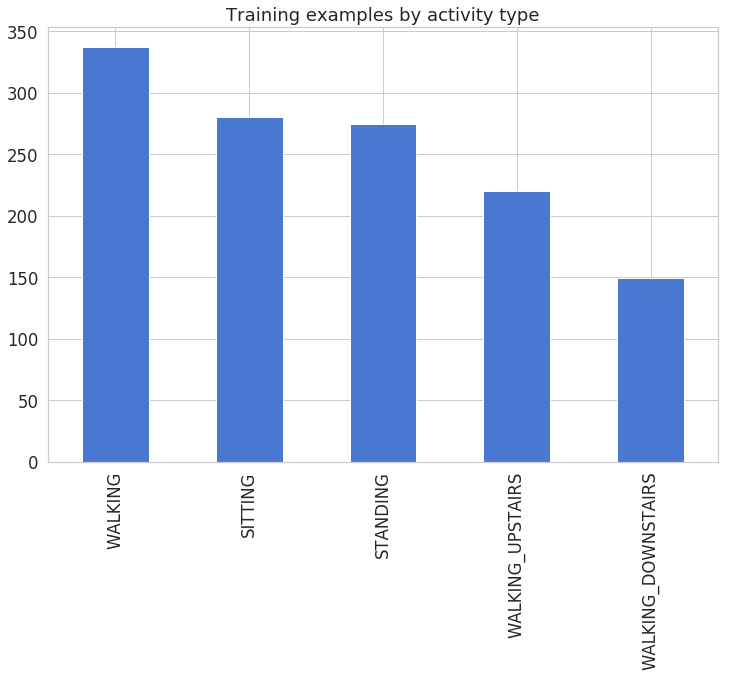

In [8]:
df['class'].value_counts().plot(kind='bar', title='Training examples by activity type');
unique_activities = np.unique(df['class'])
print(unique_activities)

The columns we will be most interested in are activity, x-axis, y-axis and z-axis. Let's dive into the data:

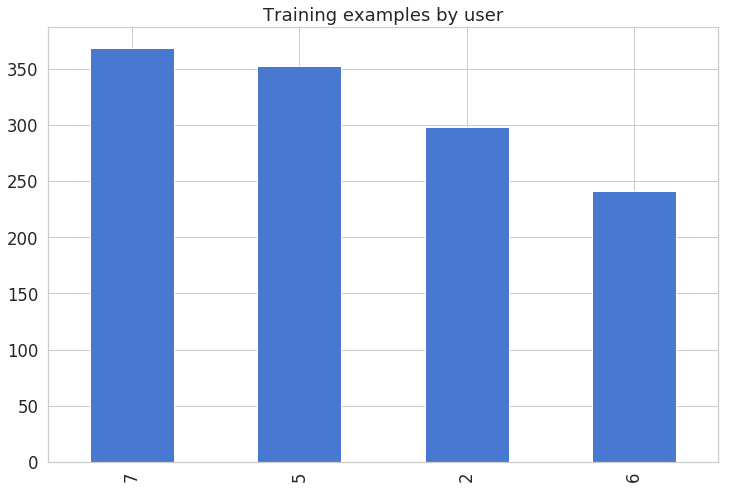

In [9]:
df['subject'].value_counts().plot(kind='bar', title='Training examples by user');

I wonder whether or not number 4 received the same paycheck as number 20. Now, for some accelerometer data:

In [0]:
def plot_activity(subject, activity, df, activity_name):
  
  one_subject_segdata = df.loc[df['subject'] == subject]
  data = one_subject_segdata[one_subject_segdata['class'] == activity][['mean_x', 'mean_y',]][:100]
  axis = data.plot(subplots=True, figsize=(18, 14), 
                   title= 'Subject: '+str(subject) + ' Activity: '+activity_name)
  for ax in axis:
      ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))

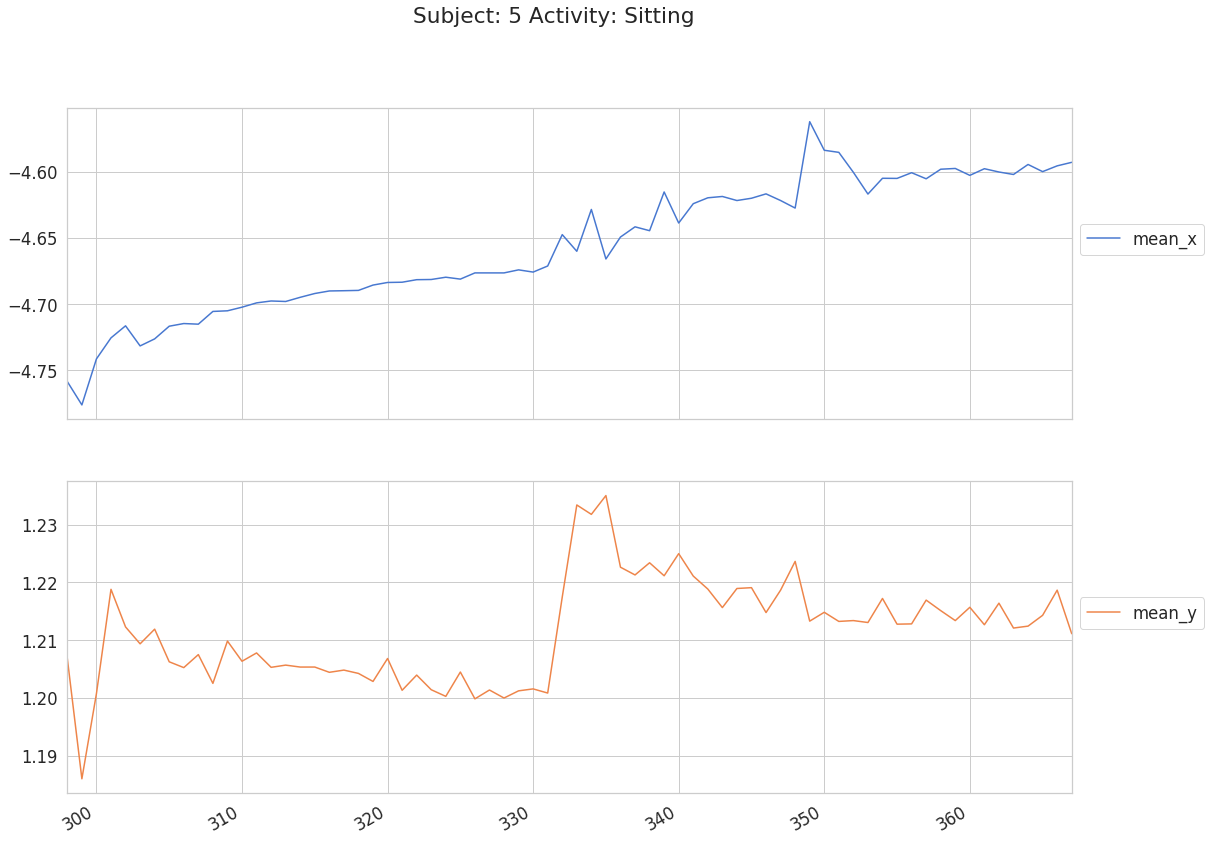

In [11]:
#plot_activity("Sitting", df)
plot_activity(5,"SITTING", df, "Sitting")

# Data Preprocessing

In [13]:
unisubs = np.unique(df['subject'])
#unisubs = np.asarray([2,5,6,7])
print(unisubs)

#one_subject_segdata = df.loc[df['subject'] == unisubs[i]]


[2 5 6 7]


In [0]:
columns = ['mean_x', 'mean_y', 'mean_z', 'magnitude_mean',
            'std_x', 'std_y', 'std_z', 'magnitude_std',
            'rms_x', 'rms_y', 'rms_z', 'magnitude_rms',
            'min_x', 'min_y', 'min_z', 'magnitude_min',
            'max_x', 'max_y', 'max_z', 'magnitude_max',
            'median_x', 'median_y', 'median_z', 'magnitude_median',
            'mad_x', 'mad_y', 'mad_z','magnitude_mad',
           'corr_xy','corr_yz', 'corr_xz',
            'subject',  'class']

N_TIME_STEPS = 10
N_FEATURES = 31
step = 5

In [0]:

def make_sequence(data):
  
  segments = []
  labels = []
  
  for i in range(0, len(data) - N_TIME_STEPS, step):
    sequence_array= []
    for j in range (0, len(columns)-2):
      sequence_array.append(data[columns[j]].values[i: i + N_TIME_STEPS])
    segments.append(sequence_array)
    
    #xs = df['x-axis'].values[i: i + N_TIME_STEPS]
    #ys = df['y-axis'].values[i: i + N_TIME_STEPS]
    #zs = df['z-axis'].values[i: i + N_TIME_STEPS]
    label = stats.mode(data['class'][i: i + N_TIME_STEPS])[0][0]
    #segments.append([xs, ys, zs])
    labels.append(label)
  
  return segments, labels

In [0]:
LABELS = ['SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS']

In [17]:

unisubs = np.unique(df['subject'])
print(unisubs)

subject = 2

train_data = df.loc[df['subject'] != subject]
test_data = df.loc[df['subject'] == subject]

print(len(train_data), len(test_data))

[2 5 6 7]
963 298


In [25]:
train_segments, train_labels = make_sequence(train_data)
test_segments, test_labels = make_sequence(test_data)

print(len (train_data),np.asarray(train_segments).shape, type(train_labels), np.asarray(train_labels).shape)
print(len (test_data),np.asarray(test_segments).shape,type(test_labels), np.asarray(test_labels).shape)



reshaped_train_segments = np.asarray(train_segments, dtype= np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
train_labels = np.asarray(pd.get_dummies(train_labels), dtype = np.float32)

reshaped_test_segments = np.asarray(test_segments, dtype= np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
test_labels = np.asarray(pd.get_dummies(test_labels), dtype = np.float32)
print(reshaped_train_segments.shape, len(train_labels))
print(reshaped_test_segments.shape, len(test_labels))

X_train = reshaped_train_segments
y_train =  train_labels
X_test = reshaped_test_segments
y_test = test_labels
  
  
  
#print(type (train_data), train_data.shape)
#print(test_data)
#print (len(train_data), len(test_data))

963 (191, 31, 10) <class 'list'> (191,)
298 (58, 31, 10) <class 'list'> (58,)
(191, 10, 31) 191
(58, 10, 31) 58


# Building the model

Our model contains 2 fully-connected and 2 LSTM layers (stacked on each other) with 64 units each:

In [0]:
N_CLASSES = 5
N_HIDDEN_UNITS = 32

In [0]:
def create_LSTM_model(inputs):
    W = {
        'hidden': tf.Variable(tf.random_normal([N_FEATURES, N_HIDDEN_UNITS])),
        'output': tf.Variable(tf.random_normal([N_HIDDEN_UNITS, N_CLASSES]))
    }
    biases = {
        'hidden': tf.Variable(tf.random_normal([N_HIDDEN_UNITS], mean=1.0)),
        'output': tf.Variable(tf.random_normal([N_CLASSES]))
    }
    
    X = tf.transpose(inputs, [1, 0, 2])
    X = tf.reshape(X, [-1, N_FEATURES])
    hidden = tf.nn.relu(tf.matmul(X, W['hidden']) + biases['hidden'])
    hidden = tf.split(hidden, N_TIME_STEPS, 0)
    
    # Stack 2 LSTM layers
    lstm_layers = [tf.contrib.rnn.BasicLSTMCell(N_HIDDEN_UNITS, forget_bias=1.0) for _ in range(2)]
    lstm_layers = tf.contrib.rnn.MultiRNNCell(lstm_layers)
    outputs, _ = tf.contrib.rnn.static_rnn(lstm_layers, hidden, dtype=tf.float32)
    '''
    lstm_layers = [tf.nn.rnn_cell.BasicLSTMCell(N_HIDDEN_UNITS, forget_bias=1.0) for _ in range(2)]
    lstm_layers = tf.nn.rnn_cell.MultiRNNCel(lstm_layers)
    outputs, _ = tf.nn.static_rnn(lstm_layers, hidden, dtype=tf.float32)
    '''
    # Get output for the last time step
    lstm_last_output = outputs[-1]

    return tf.matmul(lstm_last_output, W['output']) + biases['output']

Now, let create placeholders for our model:

In [0]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, N_TIME_STEPS, N_FEATURES], name="input")
Y = tf.placeholder(tf.float32, [None, N_CLASSES])

Note that we named the input tensor, that will be useful when using the model from Android. Creating the model:

In [29]:
pred_Y = create_LSTM_model(X)

pred_softmax = tf.nn.softmax(pred_Y, name="y_")

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Again, we must properly name the tensor from which we will obtain predictions. We will use L2 regularization and that must be noted in our loss op:

In [30]:
L2_LOSS = 0.0015

l2 = L2_LOSS * \
    sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = pred_Y, labels = Y)) + l2

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



Finally, let's define optimizer and accuracy ops:

In [0]:
LEARNING_RATE = 0.0025

optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)

correct_pred = tf.equal(tf.argmax(pred_softmax, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, dtype=tf.float32))

# Training

The training part contains a lot of TensorFlow boilerplate. We will train our model for 50 epochs and keep track of accuracy and error:

In [0]:
N_EPOCHS = 50
BATCH_SIZE = 16

In [33]:
saver = tf.train.Saver()

history = dict(train_loss=[], 
                     train_acc=[], 
                     test_loss=[], 
                     test_acc=[])

sess=tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

train_count = len(X_train)

for i in range(1, N_EPOCHS + 1):
    for start, end in zip(range(0, train_count, BATCH_SIZE),
                          range(BATCH_SIZE, train_count + 1,BATCH_SIZE)):
        sess.run(optimizer, feed_dict={X: X_train[start:end],
                                       Y: y_train[start:end]})

    _, acc_train, loss_train = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_train, Y: y_train})

    _, acc_test, loss_test = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_test, Y: y_test})

    history['train_loss'].append(loss_train)
    history['train_acc'].append(acc_train)
    history['test_loss'].append(loss_test)
    history['test_acc'].append(acc_test)

    '''
    if i != 1 and i % 10 != 0:
        continue
    '''
    print(f'epoch: {i} test accuracy: {acc_test} loss: {loss_test}')
    
predictions, acc_final, loss_final = sess.run([pred_softmax, accuracy, loss], feed_dict={X: X_test, Y: y_test})

print()
print(f'final results: accuracy: {acc_final} loss: {loss_final}')

epoch: 1 test accuracy: 0.4655172526836395 loss: 2.215946674346924
epoch: 2 test accuracy: 0.7068965435028076 loss: 1.8349205255508423
epoch: 3 test accuracy: 0.7931034564971924 loss: 1.640408992767334
epoch: 4 test accuracy: 0.8275862336158752 loss: 1.5586674213409424
epoch: 5 test accuracy: 0.8620689511299133 loss: 1.4889023303985596
epoch: 6 test accuracy: 0.8275862336158752 loss: 1.4674363136291504
epoch: 7 test accuracy: 0.8793103694915771 loss: 1.3931471109390259
epoch: 8 test accuracy: 0.8103448152542114 loss: 1.491349220275879
epoch: 9 test accuracy: 0.8793103694915771 loss: 1.3534839153289795
epoch: 10 test accuracy: 0.8275862336158752 loss: 1.48112952709198
epoch: 11 test accuracy: 0.7758620977401733 loss: 1.5775461196899414
epoch: 12 test accuracy: 0.6724137663841248 loss: 2.547646999359131
epoch: 13 test accuracy: 0.7413793206214905 loss: 1.6626782417297363
epoch: 14 test accuracy: 0.8275862336158752 loss: 1.4141520261764526
epoch: 15 test accuracy: 0.8620689511299133 loss:

In [0]:
pickle.dump(predictions, open("predictions.p", "wb"))
pickle.dump(history, open("history.p", "wb"))

Whew, that was a lot of training. Do you feel thirsty? Let's store our precious model to disk:

In [35]:

#tf.train.write_graph(sess.graph_def, '.', './checkpoint/har.pbtxt')  
#saver.save(sess, save_path = "./checkpoint/har.ckpt")

tf.train.write_graph(sess.graph_def, '.', 'checkpoint/har.pbtxt')  
saver.save(sess, save_path = "checkpoint/har.ckpt")


'''
pickle.dump(predictions, open("predictions.p", "wb"))
pickle.dump(history, open("history.p", "wb"))
#tf.train.write_graph(sess.graph_def, '.', './checkpoint/har.pbtxt')  
#saver.save(sess, save_path = "./checkpoint/har.ckpt")

tf.train.write_graph(sess.graph_def, '.', 'har.pbtxt')  
saver.save(sess, save_path = "har.ckpt")
sess.close()


'''

'\npickle.dump(predictions, open("predictions.p", "wb"))\npickle.dump(history, open("history.p", "wb"))\n#tf.train.write_graph(sess.graph_def, \'.\', \'./checkpoint/har.pbtxt\')  \n#saver.save(sess, save_path = "./checkpoint/har.ckpt")\n\ntf.train.write_graph(sess.graph_def, \'.\', \'har.pbtxt\')  \nsaver.save(sess, save_path = "har.ckpt")\nsess.close()\n\n\n'

In [0]:
sess.close()

And loading it back:

In [0]:
history = pickle.load(open("history.p", "rb"))
predictions = pickle.load(open("predictions.p", "rb"))

# Evaluation

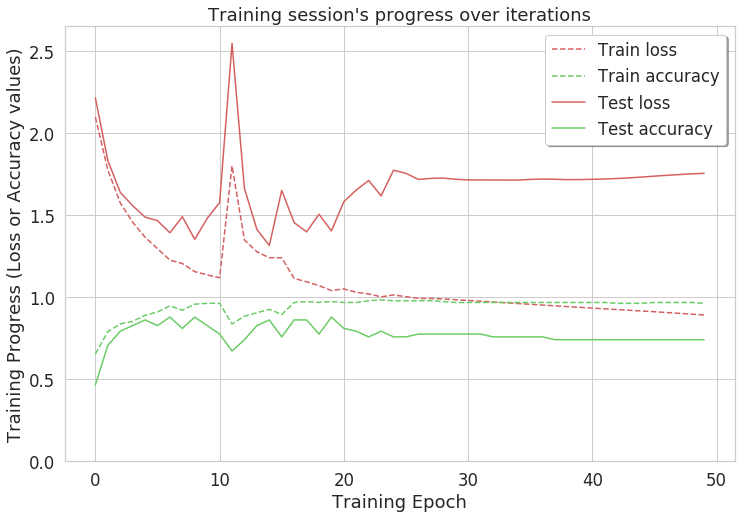

In [38]:
plt.figure(figsize=(12, 8))

plt.plot(np.array(history['train_loss']), "r--", label="Train loss")
plt.plot(np.array(history['train_acc']), "g--", label="Train accuracy")

plt.plot(np.array(history['test_loss']), "r-", label="Test loss")
plt.plot(np.array(history['test_acc']), "g-", label="Test accuracy")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training Epoch')
plt.ylim(0)

plt.show()

Our model seems to learn well with accuracy reaching above 97% and loss hovering at around 0.2. Let's have a look at the confusion matrix for the model's predictions:

In [0]:
#LABELS = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
LABELS = ['SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS']

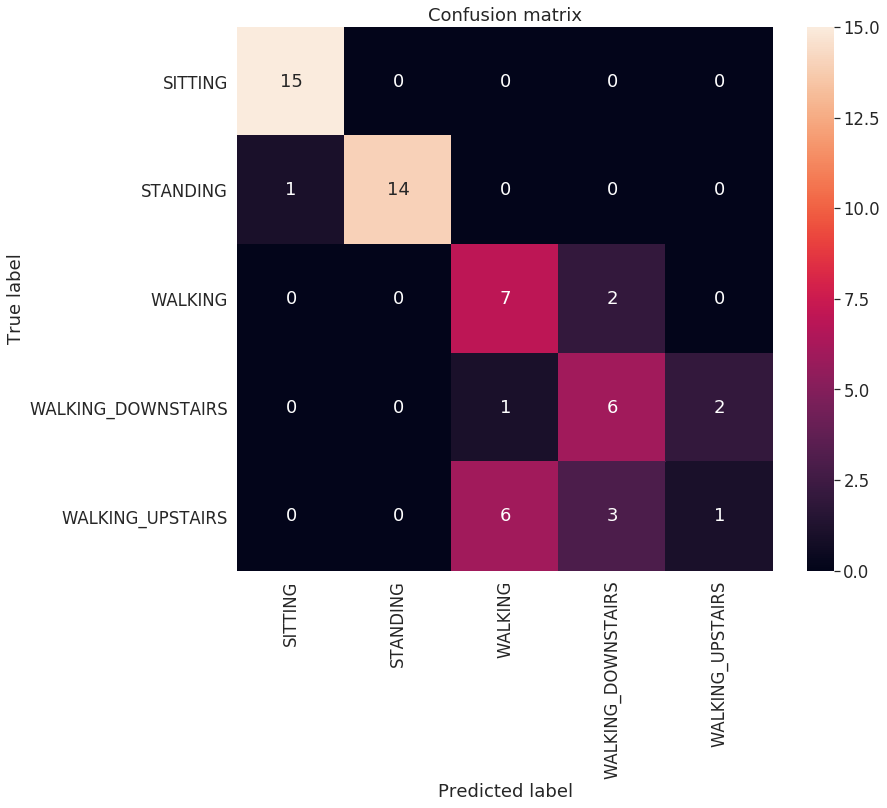

In [40]:
max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)
confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)

plt.figure(figsize=(12, 10))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show();

In [41]:
# tensprflow cpu VERSION 1.13.1
print(tf.__version__)

1.14.0


Again, it looks like our model performs real good. Some notable exceptions include the misclassification of  Upstairs for Downstairs and vice versa. Jogging seems to fail us from time to time as well!

# Exporting the model

Now that most of the hard work is done we must export our model in a way that TensorFlow for Android will understand it:

In [42]:
from tensorflow.python.tools import freeze_graph

#MODEL_NAME = 'har'
MODEL_NAME = 'har'

input_graph_path = 'checkpoint/' + MODEL_NAME+'.pbtxt'
checkpoint_path = './checkpoint/' +MODEL_NAME+'.ckpt'
restore_op_name = "save/restore_all"
filename_tensor_name = "save/Const:0"
output_frozen_graph_name = 'frozen_'+MODEL_NAME+'.pb'
#output_frozen_graph_name = 'frozen_model_new2'+'.pb'

freeze_graph.freeze_graph(input_graph_path, input_saver="",
                          input_binary=False, input_checkpoint=checkpoint_path, 
                          output_node_names="y_", restore_op_name="save/restore_all",
                          filename_tensor_name="save/Const:0", 
                          output_graph=output_frozen_graph_name, clear_devices=True, initializer_nodes="")

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./checkpoint/har.ckpt
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 8 variables.
INFO:tensorflow:Converted 8 variables to const ops.


node {
  name: "input"
  op: "Placeholder"
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "shape"
    value {
      shape {
        dim {
          size: -1
        }
        dim {
          size: 10
        }
        dim {
          size: 31
        }
      }
    }
  }
}
node {
  name: "Variable"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_FLOAT
        tensor_shape {
          dim {
            size: 31
          }
          dim {
            size: 32
          }
        }
        tensor_content: "\335\n\225?\230\325\260\277F\010G\277\223 \000\300\244\213\346>\204\347$\277\2166\220>\026|\021?\224\212(?\316\373\037?\373\330<\277?DH?\327\267{?y*\002\275K\234R?\353\226\020\277\262.\013?\202\221\321\276\203,,\277s\n\025?h\212\201\2766\343\221?6N\251\277\322\235\031?\226C^>SI\343\277aC\226?#\234\221\277\304fw?$1\224\277\320\225(=\244h+?8\rk\

#convert to tflite model

In [43]:
# tensprflow cpu VERSION 1.13.1
# print(tf.__version__)

graph_def_file = 'frozen_'+MODEL_NAME+'.pb'
#graph_def_file = "frozen_model_new2.pb"
input_arrays = ["input"]
output_arrays = ["y_"]

converter = tf.lite.TFLiteConverter.from_frozen_graph(
  graph_def_file, input_arrays, output_arrays)
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

127812

In [44]:

# Check the converted TensorFlow Lite model.
interpreter = tf.lite.Interpreter(model_content=tflite_model)

try:
  interpreter.allocate_tensors()
except ValueError:
  assert False

MINI_BATCH_SIZE = 1
correct_case = 0
for i in range(len(X_test)):
  input_index = (interpreter.get_input_details()[0]['index'])
  interpreter.set_tensor(input_index, X_test[i * MINI_BATCH_SIZE: (i + 1) * MINI_BATCH_SIZE])
  interpreter.invoke()
  output_index = (interpreter.get_output_details()[0]['index'])
  result = interpreter.get_tensor(output_index)
  # Reset all variables so it will not pollute other inferences.
  interpreter.reset_all_variables()
  # Evaluate.
  #print(result)
  prediction = np.argmax(result)
  #print(prediction, y_test[i],np.argmax(y_test[i]))
  if prediction == np.argmax(y_test[i]):
    correct_case += 1
print (correct_case)
print('TensorFlow Lite Evaluation result is {}'.format(correct_case * 1.0 / len(X_test)))

43
TensorFlow Lite Evaluation result is 0.7413793103448276
